<a href="https://colab.research.google.com/github/Tanvi-Gajula/Projects/blob/main/DLIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Succes

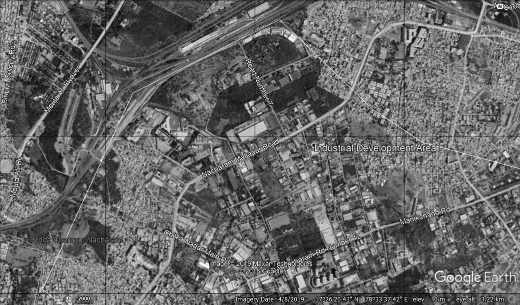

In [ ]:
# Importing necessary libraries
import cv2 as cv
import cv2  # Importing cv2 module as cv2 (renaming)
from google.colab.patches import cv2_imshow  # Importing cv2_imshow function for displaying images

# Reading an image file named 'satimag.png' in grayscale using OpenCV (cv)
img1 = cv.imread('/content/satimag.png', cv.IMREAD_GRAYSCALE)

# Getting the height and width of the original image
height, width = img1.shape

# Resizing the original image (img1) to one-third of its original size using cv2.resize function
fix = cv2.resize(img1, (width // 3, height // 3))

# Displaying the resized image using cv2_imshow function
cv2_imshow(fix)

In [ ]:
fix.shape

(305, 520)

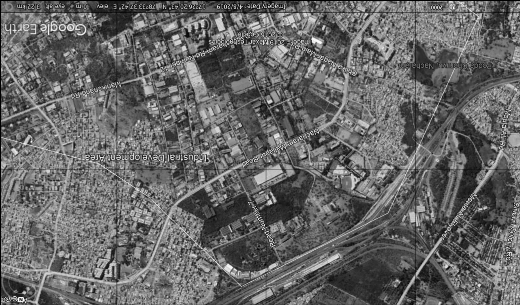

In [ ]:
# Importing necessary libraries
import cv2 as cv
from google.colab.patches import cv2_imshow  # Importing cv2_imshow function for displaying images

# Define rotation angle
rotation_angle = 180

# Calculate the rotation matrix using cv.getRotationMatrix2D
rotation_matrix = cv.getRotationMatrix2D((fix.shape[1] / 2, fix.shape[0] / 2), rotation_angle, 1)

# Apply the affine transformation to rotate the image using cv.warpAffine
mov = cv.warpAffine(fix, rotation_matrix, (fix.shape[1], fix.shape[0]), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)

# Display the rotated and resized image
cv2_imshow(mov)

In [ ]:
mov.shape

(305, 520)

In [ ]:
dataset = [(fix,mov)] # creating the dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define a function to create a stage 1 model
def stage1_model(input_shape):
  model = keras.Sequential()  # Create a Sequential model instance for stage 1

  # Add convolutional layers to extract features
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Flatten the output to feed into fully connected layers
  model.add(layers.Flatten())

  # Add fully connected layers for classification/regression
  model.add(layers.Dense(64, activation='relu'))  # 64 neurons in the hidden layer
  model.add(layers.Dense(6, name='affine_parameters'))  # Output layer with 6 neurons for affine parameters


  return model

def stage2_model(input_shape):
    model = keras.Sequential()  # Create a Sequential model instance for stage 2

    # Add convolutional layers to extract features
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output to feed into fully connected layers
    model.add(layers.Flatten())

    # Add fully connected layers for classification/regression
    model.add(layers.Dense(128, activation='relu'))  # 128 neurons in the hidden layer
    model.add(layers.Dense(6, name='deformable_parameters'))  # Output layer with 6 neurons for deformable parameters

    return model

In [ ]:
import cv2
import numpy as np

# Initialize an empty list to store image pairs
image_pairs = []

# Iterate over each pair of fixed and moving images in the dataset
for fix, mov in dataset:
    # For each pair, assign the fixed image to 'fixed_img' and the moving image to 'moving_img'
    fixed_img = fix
    moving_img = mov

    # Append the pair of images (fixed and moving) to the list 'image_pairs'
    image_pairs.append((fixed_img, moving_img))

# Convert the list of image pairs into a NumPy array
image_pairs = np.array(image_pairs)

In [ ]:
input_shape = (height // 3, width // 3, 1) # reshaping

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Define constants
batch_size = 2  # Batch size for training
epochs = 10  # Number of epochs for training
num_stages = 2  # Number of stages for transformation

# Initialize a list to store transformed images
warped_images = []

# Iterate over each stage of transformation
for stage in range(num_stages):
    # Choose the appropriate model based on the current stage
    if stage == 0:
        current_model = stage1_model(input_shape)
    else:
        current_model = stage2_model(input_shape)

    # Compile the model with Adam optimizer and mean squared error loss
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    current_model.compile(optimizer=optimizer, loss='mean_squared_error')
    current_model.summary()

    # Iterate over each pair of fixed and moving images
    for fixed_image, moving_image in image_pairs:
        # Prepare input data for the model
        # Extract the movidef model(input_shape):ng image from the image_pairs array
        input_data = image_pairs[:, 1, :, :]  # Assuming the moving image is the second element in each pair
        input_data = input_data[:, :, :, np.newaxis]  # Add a new axis for compatibility with model input

        target_data = image_pairs[:, 0, :, :]  # fixed image
        target_data = input_data[:, :, :, np.newaxis]

        # Train the model on the input data
        current_model.fit(input_data, target_data, batch_size=batch_size, epochs=epochs)

        # Predict the transformation on the moving image using the trained model
        transformed_moving_image = current_model.predict(np.array([moving_image]))[0]


        # Append the fixed image and the transformed moving image to the list of warped images
        warped_images.append((fixed_image, transformed_moving_image))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 305, 520, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 152, 260, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 152, 260, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 76, 130, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 632320)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

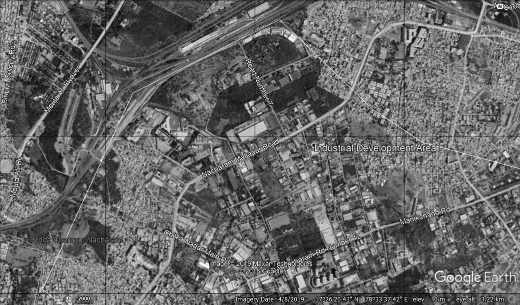

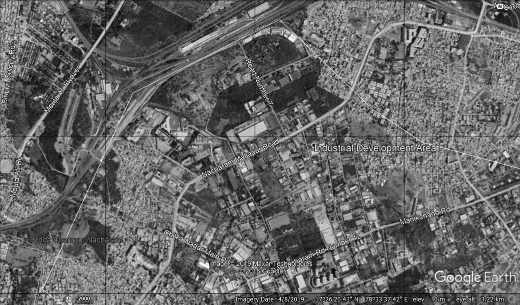

In [ ]:
# Assign the list of warped images to the variable 'image_pairs'
image_pairs = warped_images

# Import necessary libraries
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow function for displaying images

# Iterate over each pair of fixed and transformed moving images in 'warped_images'
for fixed_image, transformed_moving_image in image_pairs:
    # Display the fixed image
    cv2_imshow(fixed_image)

    # Display the transformed moving image
    cv2_imshow(transformed_moving_image)